In [2]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator

In [3]:
data_dir = '/Users/michael/Dropbox/work/data/dartbrains/data/localizer'
layout = BIDSLayout(data_dir,derivatives=True)

/usr/local/Caskroom/miniconda/base/envs/pymri/lib/python3.10/site-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


Load in the preprocessed data from one participant:

In [67]:
sbj = 'S01'
task = 'localizer'

bold_file = layout.get(subject=sbj,task=task,scope='derivatives',
                       suffix='bold',extension='nii.gz',return_type='file')
bold = Brain_Data(bold_file)
TR = layout.get_tr() # TR duration
n_TR = len(bold) # number of volumes (i.e., TRs) 

## Building a design matrix

### Experiment events

We can read in the events file from the BIDS dataset using pandas, then leverage nltools' `onsets_to_dm` function to turn these events into a `Design_Matrix` instance.

In [56]:
events_file = layout.get(subject=sbj,scope='raw',task=task,suffix='events',return_type='file')[0]
events = pd.read_csv(events_file,sep='\t')
events.head(10)

,onset,duration,trial_type
0,0.0,1,video_computation
1,2.4,1,video_computation
2,8.7,1,horizontal_checkerboard
3,11.4,1,audio_right_hand
4,15.0,1,audio_sentence
5,18.0,1,video_right_hand
6,20.7,1,audio_sentence
7,23.7,1,audio_left_hand
8,26.7,1,video_left_hand
9,29.7,1,audio_sentence


`onsets_to_dm` is looking for columns with specific names (i.e., Onset, Duration, and Stim). So, we have to relabel the columns in the events data structure before calling `onsets_to_dm`. 

In [57]:
events.columns = ['Onset','Duration','Stim']
dm = onsets_to_dm(events,sampling_freq=1/TR,run_length=n_TR)
dm.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   video_computation        128 non-null    float64
 1   horizontal_checkerboard  128 non-null    float64
 2   audio_right_hand         128 non-null    float64
 3   audio_sentence           128 non-null    float64
 4   video_right_hand         128 non-null    float64
 5   audio_left_hand          128 non-null    float64
 6   video_left_hand          128 non-null    float64
 7   vertical_checkerboard    128 non-null    float64
 8   audio_computation        128 non-null    float64
 9   video_sentence           128 non-null    float64
dtypes: float64(10)
memory usage: 10.1 KB


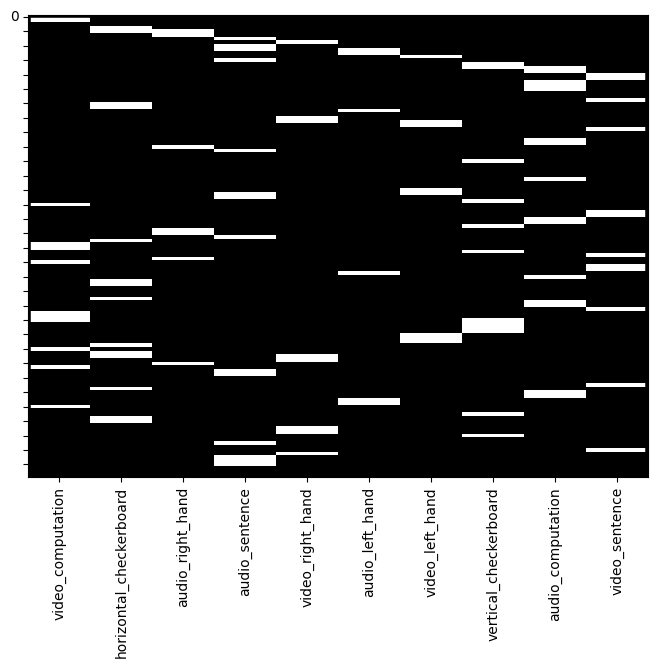

In [58]:
dm.heatmap()

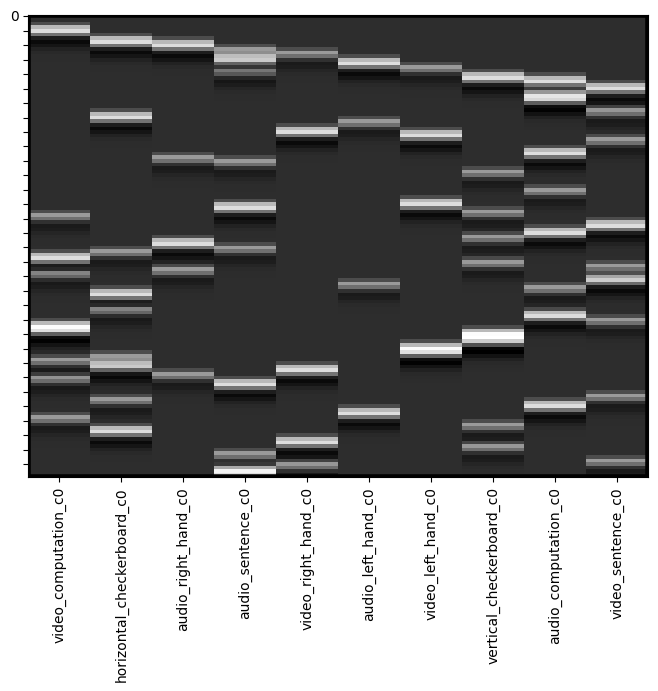

In [59]:
dm_conv = dm.convolve()
dm_conv.heatmap()

## Nuisance covariates

Don't forget about all those motion-related, high-pass filtering, and other nusiance covariates! 

### High-pass filtering

First up, high-pass filtering with DCT basis functions. nltools has a nice helper method to add these to any `DesignMatrix` instance:

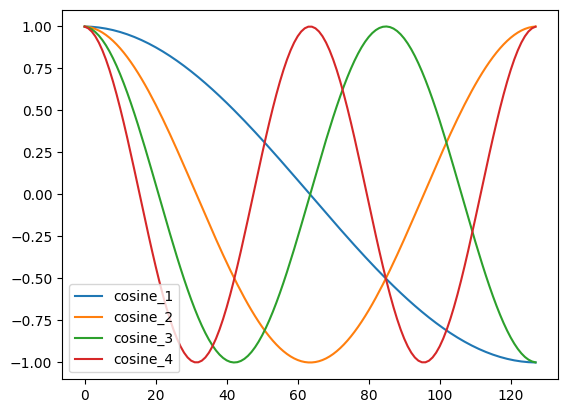

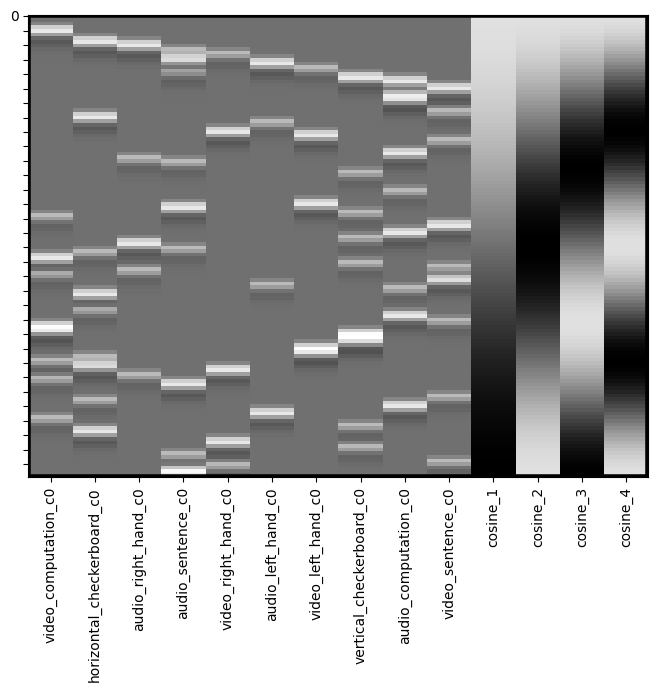

In [60]:
dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt.iloc[:,10:].plot()
dm_conv_filt.heatmap()

### Intercept and linear trends

Add in both an intercept and linear trend covariates with the `.add_poly()` method. The linear trends covariates remove slow drifts in the data that are common with fMRI. You can define polynomials with a specific order (1 = linear, 2 = quadratic) and setting `include_lower` to `True` will include all lower order covariates.

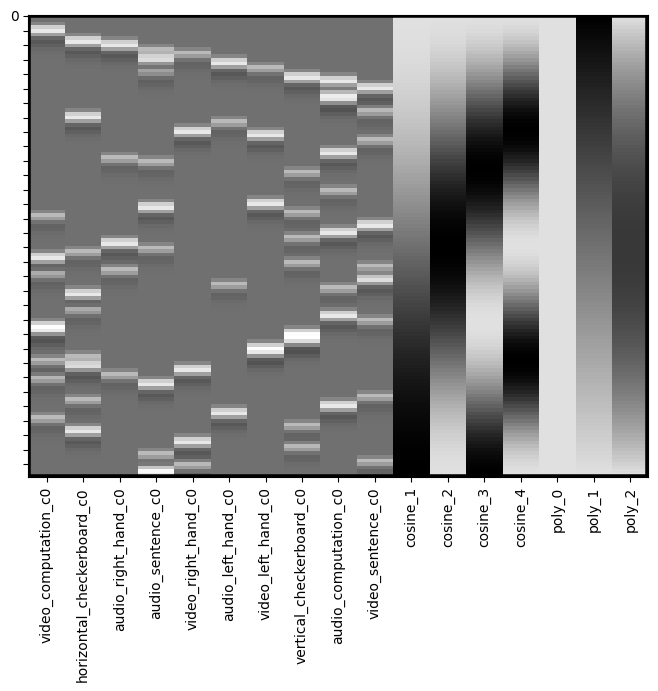

In [62]:
dm_conv_filt_poly = dm_conv_filt.add_poly(order=2,include_lower=True)
dm_conv_filt_poly.heatmap()

### Motion-related covariates

Head motion can introduce artifacts in BOLD measures. Although preprocessing typically includes motion correction such that BOLD timeseries are aligned across TRs, including covariates related to head motion is important in univariate modeling. If you are using fmriprep for preprocessing, these motion-related covariates are calculated and stored in a confounds file. Here's how to use it:

In [63]:
confound_file = layout.get(subject='S01',scope='derivatives',extension='.tsv',return_type='file')[0]
print(confound_file)
confounds = pd.read_csv(confound_file,sep='\t')
confounds.head()


/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/sub-S01/func/sub-S01_task-localizer_desc-confounds_regressors.tsv


,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,white_matter_power2,white_matter_derivative1_power2,global_signal,global_signal_derivative1,...,rot_x_derivative1_power2,rot_x_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2
0,5164.630182,NaN,NaN,2.667340e+07,4006.007667,NaN,1.604810e+07,NaN,3753.537871,NaN,...,NaN,4.016403e-07,0.000344,NaN,NaN,1.180596e-07,-0.000701,NaN,NaN,4.914346e-07
1,5178.481411,13.851229,191.856548,2.681667e+07,4011.819383,5.811716,1.609469e+07,33.776043,3760.408417,6.870546,...,8.622980e-09,2.925631e-07,0.000569,0.000225,5.063355e-08,3.233253e-07,-0.000776,-0.000075,5.666476e-09,6.026417e-07
2,5161.040643,-17.440768,304.180395,2.663634e+07,4006.766409,-5.052974,1.605418e+07,25.532548,3756.426086,-3.982332,...,6.975673e-08,6.480347e-07,0.000655,0.000086,7.409422e-09,4.286255e-07,-0.000524,0.000253,6.390582e-08,2.740564e-07
3,5150.604178,-10.436465,108.919794,2.652872e+07,4008.586021,1.819612,1.606876e+07,3.310987,3751.566090,-4.859996,...,1.673784e-07,1.567265e-07,0.000554,-0.000101,1.011674e-08,3.070412e-07,-0.000605,-0.000082,6.722360e-09,3.666230e-07
4,5172.441161,21.836983,476.853810,2.675415e+07,4007.189291,-1.396730,1.605757e+07,1.950854,3746.298200,-5.267890,...,2.102616e-08,2.925631e-07,0.000997,0.000443,1.959195e-07,9.934926e-07,-0.000840,-0.000235,5.510428e-08,7.059982e-07


As you can see above, the confounds file includes many different measures of potential confounds. Select the ones that you care about and create a `Design_Matrix` instance with them. Below, we are selecting global singal, framewise displacement, and 24 covariates related to motion. fmriprep also provides covariates for potential spikes (columns labeled as motion_outlier* in the confounds file), so we will include those too.

<AxesSubplot: >

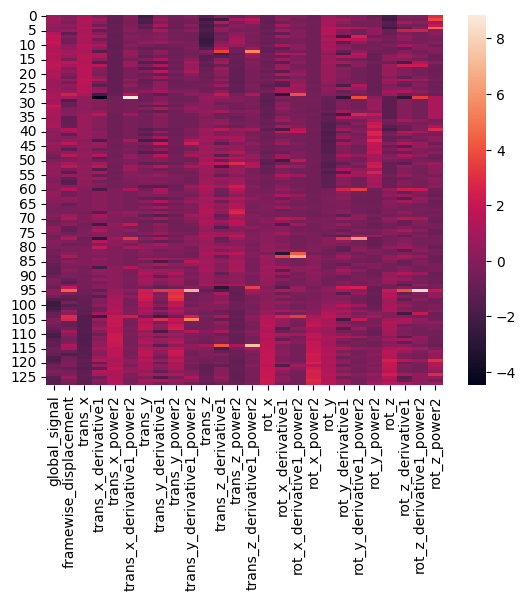

In [71]:
# covariate column names to include
inc = ['global_signal','framewise_displacement', \
       'trans_x','trans_x_derivative1','trans_x_power2','trans_x_derivative1_power2', \
       'trans_y','trans_y_derivative1','trans_y_power2','trans_y_derivative1_power2', \
       'trans_z','trans_z_derivative1','trans_z_power2','trans_z_derivative1_power2', \
       'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2', \
       'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2', \
       'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2']
mc = confounds[inc]
z_mc = zscore(mc)
z_mc.fillna(value=0,inplace=True) # NAs need to be replaced with 0s
# find any potential spike covariates
spikes = confounds.loc[:,confounds.columns.str.startswith('motion_outlier')]
# create the motion related design matrix
nuisance = Design_Matrix(pd.concat([z_mc,spikes],axis=1),sampling_freq=1/TR)

sns.heatmap(nuisance)

### Putting it all together

We can create our final design matrix that includes our events, high-pass filtering, polynomials, and motion-related covariates with a pandas `concat()` call becasue `Design_Matrix` is based on the pandas `DataFrame` structure. So, undernearth it all, anything you can do with a pandas `DataFrame` you can do with a `Design_Matrix`.

<AxesSubplot: >

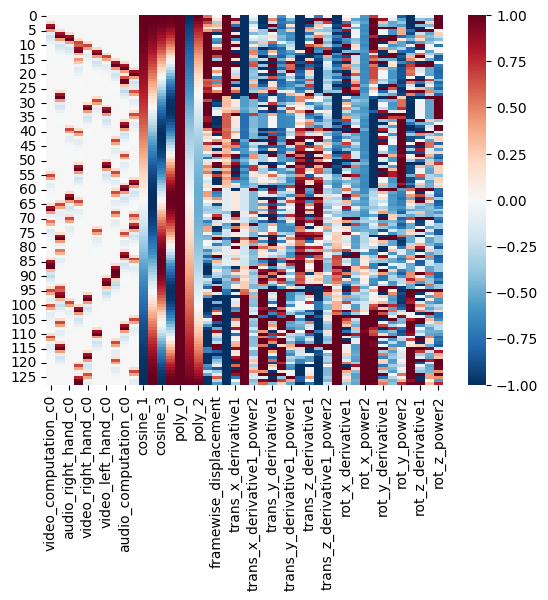

In [75]:
dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly,nuisance],axis=1)
sns.heatmap(dm_conv_filt_poly_cov,cmap='RdBu_r',vmin=-1,vmax=1)

## Smoothing

With a finished design matrix, we can now return to the BOLD data. It is common to smooth data to increase signal-to-noise ratio (which helps with the assumptions of random field theory). Smoothing is a method attached to any `Brain_Data` instance and has a default 3D Gaussian smoothing kernel defined by the full width half maximum (FWHM).

In [78]:
fwhm = 6
smoothed = data.smooth(fwhm=fwhm)

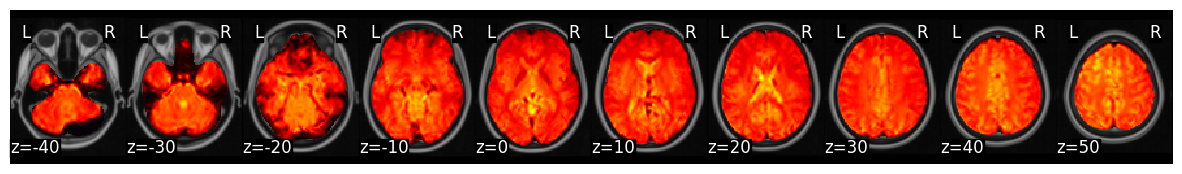

In [79]:
data.mean().plot()

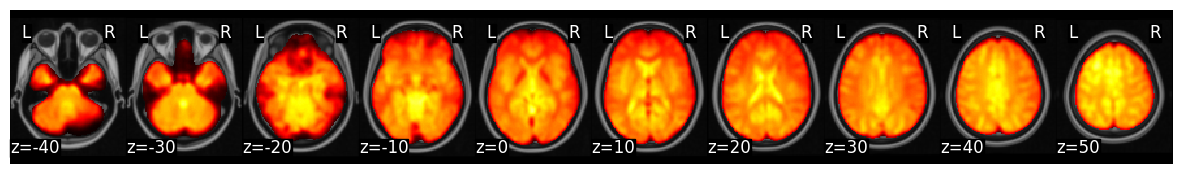

In [80]:
smoothed.mean().plot()

## Estimate GLM

We are finally ready to estimate the GLM for all voxels. To do so, we will assign the full design matrix to the `X` attribute of our smoothed data and run the `regress()` method.

In [81]:
smoothed.X = dm_conv_filt_poly_cov
stats = smoothed.regress()

print(stats.keys())

dict_keys(['beta', 't', 'p', 'df', 'sigma', 'residual'])


In [84]:
print(smoothed.X.columns)
stats['beta'].iplot()

Index(['video_computation_c0', 'horizontal_checkerboard_c0',
       'audio_right_hand_c0', 'audio_sentence_c0', 'video_right_hand_c0',
       'audio_left_hand_c0', 'video_left_hand_c0', 'vertical_checkerboard_c0',
       'audio_computation_c0', 'video_sentence_c0', 'cosine_1', 'cosine_2',
       'cosine_3', 'cosine_4', 'poly_0', 'poly_1', 'poly_2', 'global_signal',
       'framewise_displacement', 'trans_x', 'trans_x_derivative1',
       'trans_x_power2', 'trans_x_derivative1_power2', 'trans_y',
       'trans_y_derivative1', 'trans_y_power2', 'trans_y_derivative1_power2',
       'trans_z', 'trans_z_derivative1', 'trans_z_power2',
       'trans_z_derivative1_power2', 'rot_x', 'rot_x_derivative1',
       'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y',
       'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
       'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2',
       'rot_z_power2'],
      dtype='object')


interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

## Contrasts



In [96]:
c1 = np.zeros(len(stats['beta']))
c1[smoothed.X.columns.str.startswith('video_')] = 1/4
c1[smoothed.X.columns.str.startswith('audio_')] = -1/4

video_audio = stats['beta']*c1
video_audio.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [94]:
sum(c1[c1>0])

4.0